# Lane Detection Approach 1

In [1]:
#Install requirements
%tensorflow_version 1.x
!pip install patchify
!pip install segmentation-models==1.0.1

TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Extracting images from KITTI dataset 



The dataset consists of multiple roads images and corresponding annotated images with pixel-wise semantic segmentation in 2 classes (Road and background). The total volume of the dataset is 289 pictures. \\
The RGB colors used for the semantic segmentation are:
- ROAD: (255 , 0 , 255) - Magenta
- BACKGROUND: (255 , 0 , 0) - Red 
- UNLABELED: (0 , 0 , 0) - Black

In [43]:
# Imports and ROOT directory definition
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from os.path import join

import cv2
import numpy as np
import glob

from PIL import Image
from patchify import patchify
from matplotlib import pyplot as plt


import segmentation_models as sm
import tensorflow
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

root_directory = '/content/drive/MyDrive/VP_project/KITTI/dataset/data_road/training/' #Path to training images
IMAGE_DATASET = '/content/drive/MyDrive/VP_project/KITTI/dataset/data_road/training/image_2/'

IMAGE_PATH = join(root_directory, IMAGE_DATASET)

Mounted at /content/drive


### Resizing and patching images of the dataset

In [44]:
#PATCHING ORIGINAL IMAGES
#***************************

# Patching process: (Really necessary? difficult to see if images correspond)
patch_size_x = 186
patch_size_y = 186

image_dataset = []  

for path, subdirs, files in os.walk(root_directory):
    #print(path)
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'image_2':   #Find image directory
        images = os.listdir(path)  #List of all image names in this subdirectory
        for image_name in sorted(images):  
            if image_name.endswith(".png"):   #Only read png images
                
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                SIZE_X = (image.shape[1]//patch_size_x)*patch_size_x #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size_y)*patch_size_y #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop form top left corner
                image = np.array(image)   

                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size_x, patch_size_y, 3), step=patch_size_x)  #no overlap
                
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)
                        
image_dataset = np.array(image_dataset)

Now patchifying image: /content/drive/MyDrive/VP_project/KITTI/dataset/data_road/training/image_2/um_000000.png
Now patchifying image: /content/drive/MyDrive/VP_project/KITTI/dataset/data_road/training/image_2/um_000001.png
Now patchifying image: /content/drive/MyDrive/VP_project/KITTI/dataset/data_road/training/image_2/um_000002.png
Now patchifying image: /content/drive/MyDrive/VP_project/KITTI/dataset/data_road/training/image_2/um_000003.png
Now patchifying image: /content/drive/MyDrive/VP_project/KITTI/dataset/data_road/training/image_2/um_000004.png
Now patchifying image: /content/drive/MyDrive/VP_project/KITTI/dataset/data_road/training/image_2/um_000005.png
Now patchifying image: /content/drive/MyDrive/VP_project/KITTI/dataset/data_road/training/image_2/um_000006.png
Now patchifying image: /content/drive/MyDrive/VP_project/KITTI/dataset/data_road/training/image_2/um_000007.png
Now patchifying image: /content/drive/MyDrive/VP_project/KITTI/dataset/data_road/training/image_2/um_000

In [45]:
#Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'gt_image_2':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for mask_name in sorted(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size_x)*patch_size_x #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size_y)*patch_size_y #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size_x, patch_size_y, 3), step=patch_size_x)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask)

mask_dataset =  np.array(mask_dataset)

Now patchifying mask: /content/drive/MyDrive/VP_project/KITTI/dataset/data_road/training/gt_image_2/um_road_000000.png
Now patchifying mask: /content/drive/MyDrive/VP_project/KITTI/dataset/data_road/training/gt_image_2/um_road_000001.png
Now patchifying mask: /content/drive/MyDrive/VP_project/KITTI/dataset/data_road/training/gt_image_2/um_road_000002.png
Now patchifying mask: /content/drive/MyDrive/VP_project/KITTI/dataset/data_road/training/gt_image_2/um_road_000003.png
Now patchifying mask: /content/drive/MyDrive/VP_project/KITTI/dataset/data_road/training/gt_image_2/um_road_000004.png
Now patchifying mask: /content/drive/MyDrive/VP_project/KITTI/dataset/data_road/training/gt_image_2/um_road_000005.png
Now patchifying mask: /content/drive/MyDrive/VP_project/KITTI/dataset/data_road/training/gt_image_2/um_road_000006.png
Now patchifying mask: /content/drive/MyDrive/VP_project/KITTI/dataset/data_road/training/gt_image_2/um_road_000007.png
Now patchifying mask: /content/drive/MyDrive/VP_

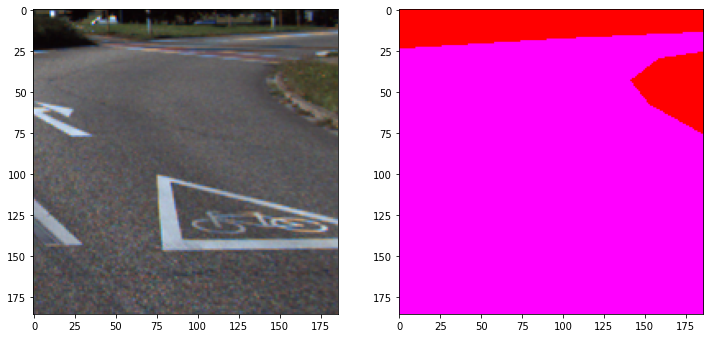

In [62]:
#Random check, to see if mask correspond to image. (Play a few times)
import random
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size_x, patch_size_y, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size_x, patch_size_y, 3)))
plt.show()

In [124]:
#Mask to labels
Road = np.array([255,0,255]) 
Back = np.array([255,0,0])
Unlabeled = np.array([0,0, 0])

# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Road,axis=-1)] = 0
    label_seg [np.all(label==Back,axis=-1)] = 1
    label_seg [np.all(label==Unlabeled,axis=-1)] = 2
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i]) #reeplace rgb vector by an unique int
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2]


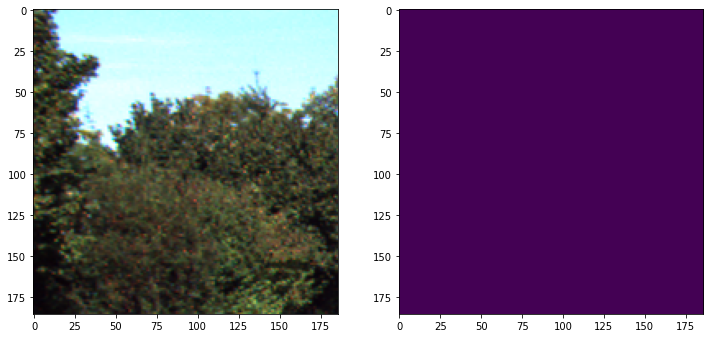

In [138]:
#Another check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

## Training process

In [139]:
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)